In [204]:
import numpy as np
from matplotlib import pyplot as plt
import cvxopt

The general convex optimization problem is:
\begin{equation}
\begin{aligned}
\text{minimize } & \frac{1}{2} \mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T\mathbf{x} \\
\text{subject to } & \mathbf{G}\mathbf{x} \leq \mathbf{h} \\
& \mathbf{A}\mathbf{x} = \mathbf{b}.
\end{aligned}
\end{equation}

In the general (soft or hard margin) SVM formulation, the equations given in Bishop, 2006 are as follows:
\begin{equation}
\begin{aligned}
\max_\mathbf{a} \text{ } & \mathcal{L}(\mathbf{a}) = \sum_{n=1}^{N}a_n - \frac{1}{2} \sum_{n=1}^{N}\sum_{m=1}^N a_n a_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m), \\
\text{such that } & 0 \leq a_n \leq C \\
\text{and } & \sum_{n=1}^{N}a_n t_n = 0 \\
\end{aligned}
\end{equation}

We can immediately see that we can rewrite this to be suitable to the convex optimisation problem: let us reformulate the convex problem with $\mathbf{x} = \mathbf{a}$ to give the following matrices (let $\otimes$ be the outer product):

\begin{equation}
\mathbf{P} = \mathbf{t}\otimes \mathbf{t} * \mathbf{K}(X),
\end{equation}
where $\mathbf{K}$ is the gram matrix:
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j),
\end{equation}

Furthermore, $\mathbf{q}$ is simply:
\begin{equation}
\mathbf{q} = -\mathbf{1}.
\end{equation}

If we solve to hard margin problem ($C = \infty$, $a_n \geq 0$), then $\mathbf{G}$ is simply the negative identify matrix.
\begin{equation}
\mathbf{G}_{hard} = - \mathbf{I}
\end{equation}
and $\mathbf{h}$ is simply a zero vector
\begin{equation}
\mathbf{h} = \mathbf{0}.
\end{equation}

However, if we solve to soft margin problem ($0\leq a_n \leq C$), $\mathbf{G}$ and $\mathbf{h}$ become
\begin{equation}
\mathbf{G}_{soft} = [\mathbf{G_1}, \mathbf{G_2}]^T
\end{equation}
\begin{equation}
\mathbf{G_1} = -\mathbf{I}
\end{equation}
\begin{equation}
\mathbf{G_2} = \mathbf{I}
\end{equation}
\begin{equation}
\mathbf{h} = [\mathbf{h}_1, \mathbf{h}_2]^T
\end{equation}
\begin{equation}
\mathbf{h}_1 = \mathbf{0}
\end{equation}
\begin{equation}
\mathbf{h}_2 = C * \mathbf{1}
\end{equation}

Finally, the final equality constraint is simple, as $\mathbf{A}$ simply $\text{diag}(\mathbf{t})$ and $\mathbf{b}$ is zero vector.
\begin{equation}
\mathbf{A} = \text{diag}(\mathbf{t})
\end{equation}
\begin{equation}
\mathbf{b} = \mathbf{0}.
\end{equation}

Alternatively, let $\mathbf{A} = \mathbf{t}^T$ and $b = 0$ (since we dot product $\mathbf{A}$ with $\mathbf{a}$). I think this last version is correct as it produces the right stuff in cvxopt.

In [205]:
class SVM(object):
    def __init__(self, kernel = 'linear', degree = 3, gamma = 1, C = None, alpha_threshold = 1e-5):
        
        self.kernel = kernel
        self.degree = degree #polynomial kernel degree
        self.gamma = gamma #Gaussian kernel 1/variance
        self.C = C
        self.alpha_threshold = alpha_threshold

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)
    
    def polynomial_kernel(self, x1, x2):
        return (1 + np.dot(x1, x2)) **self.degree
    
    def gaussian_kernel(self, x1, x2):
        return np.exp(-1 * self.gamma * (np.linalg.norm(x1 - x2)**2))
    
    def apply_kernel_function(self, x1, x2):
        
        if self.kernel == 'linear':
            return self.linear_kernel(x1, x2)
        
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x1, x2)
            
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x1, x2)
        
        else:
            print("Illegal kernel function chosen.")
            raise SystemExit
    
    def calculate_gram(self, X):
        n, f = X.shape
        
        K = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                K[i, j] = self.apply_kernel_function(X[i, :], X[j, :])
        
        return K
    
    def fit(self, X, y):
        
        #Determine gram matrix
        Gram = self.calculate_gram(X)
        
        #Setup necessary matrices to be used for lagrangian multipliers
        #P and q
        n = X.shape[0]
        P = cvxopt.matrix(np.outer(y, y) * Gram)
        q = cvxopt.matrix(-1 * np.ones((n, 1)))
        
        #G and h
        if self.C is None:
            print("\nSolving the hard margin problem!")
            G = cvxopt.matrix(-1 * np.eye(n))
            h = cvxopt.matrix(np.zeros((n, 1)))
            
        else:
            print("\nSolving the soft margin problem!")
            G_1 = -1 * np.eye(n)
            h_1 = np.zeros((n, 1))
            
            G_2 = np.eye(n)
            h_2 = self.C * np.ones((n, 1))
            
            G = cvxopt.matrix(np.vstack((G_1, G_2)))
            h = cvxopt.matrix(np.vstack((h_1, h_2)))
        
        #A and b
        #A = cvxopt.matrix(np.diag(y))
        #b = cvxopt.matrix(np.zeros((n, 1)))
        #OR
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.zeros((1, 1)))
        
        #We are now ready to solve the convex optimisation problem!
        self.solution = cvxopt.solvers.qp(P, q, G, h, A, b)  
        print(self.solution)
        
        #Save alphas
        self.alphas = np.array(self.solution['x'])[:, 0]
        
        #Setup index lists!
        support_alpha_indices = []
        
        for cnt, i in enumerate(self.alphas):
            if i >= self.alpha_threshold:
                support_alpha_indices.append(cnt)
        
        self.support_alpha_indices = support_alpha_indices
        self.support_alphas = self.alphas[self.support_alpha_indices]
        self.support_vectors = X[self.support_alpha_indices, :]
        self.support_labels = y[self.support_alpha_indices]
        self.sv_weights = self.support_alphas * self.support_labels
        
        #Calculate intercept
        self.b = 0
        
        for cnt_i, i in enumerate(self.support_alpha_indices):
            self.b += self.support_labels[cnt_i]
            
            for cnt_j, j in enumerate(self.support_alpha_indices):
                self.b -= self.support_alphas[cnt_j] * self.support_labels[cnt_j] * Gram[i, j]
        
        self.b /= len(self.support_alpha_indices)       
    
    def predict(self, X):
        
        if len(X.shape) > 1:
            
            n = X.shape[0]
            prediction = np.zeros(n)
            
            for i in range(n):
                prediction[i] = self.evaluate_model(X[i, :])
        else:
            prediction = self.evaluate_model(X)
        
        return np.sign(prediction)
    
    def evaluate_model(self, x):
        #x = (N,) array
        
        y = 0
        for i in range(len(self.support_alpha_indices)):
            y += self.sv_weights[i] * self.apply_kernel_function(x, self.support_vectors[i, :])
        
        y += self.b
        
        return y
        
        
        

(200,)


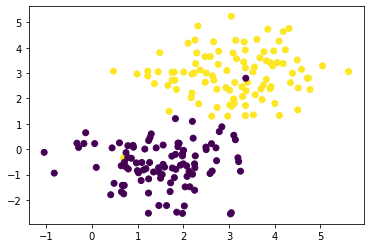

1.0

In [206]:
X1 = np.random.randn(100, 2) + np.array([3, 3])
X2 = np.random.randn(100, 2) + np.array([1.5, -0.5])

l1 = np.ones(100)
l2 = -1 * np.ones(100)
X = np.vstack((X1, X2))
labels = np.hstack((l1, l2))

print(labels.shape)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = L)
plt.show()


np.outer(L, L)[0, 99]


Solving the hard margin problem!
     pcost       dcost       gap    pres   dres
 0: -2.4152e+01 -8.8887e+01  6e+02  1e+01  3e+00
 1: -6.6327e+01 -1.7846e+02  4e+02  8e+00  1e+00
 2: -1.9205e+02 -3.2516e+02  3e+02  6e+00  1e+00
 3: -5.4755e+02 -7.5776e+02  4e+02  5e+00  1e+00
 4: -9.3383e+02 -1.2235e+03  5e+02  4e+00  8e-01
 5: -1.4733e+03 -1.8368e+03  5e+02  3e+00  5e-01
 6: -1.6768e+03 -1.8261e+03  2e+02  6e-01  1e-01
 7: -1.6844e+03 -1.7003e+03  2e+01  5e-02  1e-02
 8: -1.6844e+03 -1.6860e+03  2e+00  1e-03  2e-04
 9: -1.6852e+03 -1.6854e+03  3e-01  2e-04  3e-05
10: -1.6853e+03 -1.6854e+03  1e-01  2e-05  4e-06
11: -1.6853e+03 -1.6853e+03  3e-03  4e-07  7e-08
12: -1.6853e+03 -1.6853e+03  3e-05  4e-09  8e-10
Optimal solution found.
{'x': <200x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <200x1 matrix, tc='d'>, 'z': <200x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 3.495967152536676e-05, 'relative gap': 2.074338564858669e-08, 'primal objective': -1685.3406728109821, 'dual objec

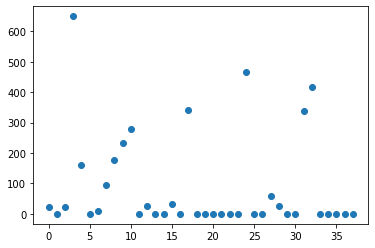

[2.37276824e+01 2.27397615e-02 2.22665910e+01 6.49283463e+02
 1.61942383e+02 4.64467480e-01 1.08042113e+01 9.63761471e+01
 1.78062562e+02 2.33220108e+02 2.80238597e+02 1.04982541e+00
 2.75126026e+01 3.69291661e-01 8.19701196e-01 3.40955595e+01
 2.18473183e-01 3.40127242e+02 2.72705471e-01 1.72369122e-01
 7.78660415e-01 1.31683436e+00 2.56881664e-01 4.50849160e-01
 4.66308704e+02 1.60531105e-05 9.59322963e-01 5.86867993e+01
 2.49979526e+01 1.54291763e-05 3.50261811e-01 3.36914090e+02
 4.15589228e+02 1.36127233e+00 4.31130197e-01 3.27509421e-01
 3.84605080e-05 9.05025307e-01]
0.5258879064594936
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1

In [201]:
svm_test = SVM('gaussian', C = None)
svm_test.fit(X, labels)

plt.figure()
plt.scatter(np.arange(len(svm_test.support_alphas)), svm_test.support_alphas)
plt.show()

print(svm_test.support_alphas)
print(svm_test.b)
print(svm_test.predict(X))

In [202]:
N_grid = 100
X_m, Y_m = np.meshgrid(np.linspace(np.min(X[:, 0]) - 2, np.max(X[:, 0]) + 2, N_grid), np.linspace(np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2, N_grid))

X_grid = np.hstack((X_m.reshape(-1, 1), Y_m.reshape(-1, 1)))

Z = []
for i in range(X_grid.shape[0]):
    Z.append(svm_test.evaluate_model(X_grid[i, :]))

Z = np.array(Z)

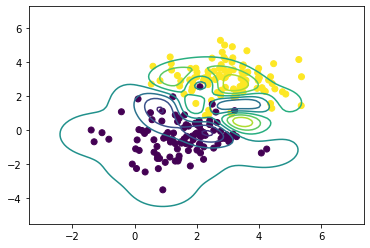

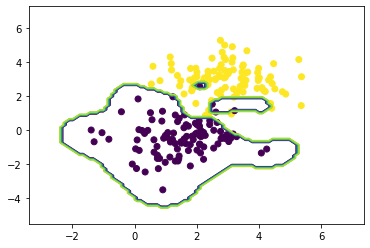

In [203]:
plt.figure()
plt.contour(X_m, Y_m, Z.reshape(N_grid, N_grid))
plt.scatter(X[:, 0], X[:, 1], c = svm_test.predict(X))
plt.show()

plt.figure()
plt.contour(X_m, Y_m, np.sign(Z.reshape(N_grid, N_grid)))
plt.scatter(X[:, 0], X[:, 1], c = svm_test.predict(X))
plt.show()